In [1]:
# INLEZEN
from mpl_toolkits.mplot3d import Axes3D
import numpy as np   
import cv2
import skimage.morphology
import scipy.ndimage as snd
from skimage import exposure       # image processing module to enhance contrast
from skimage import io, color
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import glob
try:
    import png  # backup when skimage backend fails 
except ImportError:
    pass
import os

np.seterr(all = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# FUNCTIONS
def read_RGB(IMAGEPATH, dims = (2448,2448,3)):
    """
        Function for reading RGB-bands from CLR.dat file
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n, k)
            dimensions of the image 
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    full = np.reshape(a, dims, order='F')
    return full

def read_SingleBand(IMAGEPATH, dims = (2448,2448), bandNr = 0):
    """
        Function for reading a specific band from a .dat file. Numbers go 
        from 0 to the number of bands in the file minus one (performance issue:
        this function reads the full image and subsequently slices the resulting
        array... performance gains might be obtained when reading selectively ...
        not a real issue at the time of implementation)
        
        PARAMETERS
        ----------
        
        IMAGEPATH : str
            absolute or relative path to the .dat file
        
        dims : tuple of ints (m, n)
            dimensions of the image 
            
        bandNr : int
            band to be read
        
    """
    f = open(IMAGEPATH, "r")
    a = np.fromfile(f, dtype=np.uint16)
    f.close()
    firstNr = (dims[0] * dims[1]) * bandNr
    length = (dims[0] * dims[1])
    full = np.reshape(a[firstNr : firstNr+length], dims, order='F')
    return full
    
def rescale(img, percentiles = None, to_uint8 = False):
    """
        Function that applies histogram stretching on an image, using the
        percentiles of the image histogram percentiles = None. --> to obtain a
        nice-looking image, rescaling is often important!
        
        If percentiles is an (a, b) tuple where a and b are floats, these values
        are used as upper and lower bounds for the stretching.
    """
    
    
    if percentiles is None:
            p2, p98 = np.percentile(img, (2, 98))
            percentiles = (p2, p98)
            
    img = exposure.rescale_intensity(img, in_range=percentiles)
    
    if img.dtype == "float64" and img.min() < 0.0:
        img = (img + 1)/2
        
    if to_uint8:
        img = img_as_ubyte(img, force_copy= True)
    return img
        
def save_as_PNG(img, fname , rescale_img = True, percentiles = None):
    """
        Function to save an image array as a png
        
        PARAMETERS
        ----------
        img : np.array
            (m, n, 3) numpy array of RGB values
    """
    if rescale_img:
        img = rescale(img, percentiles = percentiles, to_uint8 = True)
    try:
        io.imsave(fname, img)
    except Exception:
        png.from_array(img, 'RGB').save(fname)

def show_RGB(img, rescale_img = True, percentiles = None):
    if rescale_img:
        img = rescale(img, percentiles = percentiles)
    plt.imshow(np.array(img, dtype=float)/65536)

def gray_to_colormapped(img, cmap = "jet"):
    """
        Function to transform a grayscale image into an RGB image using a particular colormap
        typical applications are heat-map like images (using jet - colormap)
    """
    assert img.dtype == 'uint8', "datatype differs from uint8 when performing gray_to_colormapped"
    if cmap == "jet":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = 175-np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "jet inv":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/1.46, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap == "fv/fm":
        tmp = np.zeros(list(img.shape) + [3], dtype = 'uint8')
        tmp[:,:,0] = np.array(img/3.5, dtype='uint8')
        tmp[:,:,1] = 255
        tmp[:,:,2] = 255
        return img_as_ubyte(color.hsv2rgb(tmp))
    
    elif cmap =='gray':
        return img_as_ubyte(color.gray2rgb(img), force_copy=True)

def convert_folder_RGB(img_path_list, percentiles = None):
    cnt = 0
    for fname in img_path_list:
        try:
            img = read_RGB(fname)
            save_as_PNG(img, fname[:-3] + "png", rescale_img = True, percentiles = percentiles)
            cnt += 1
        except Exception:
            pass
    return cnt

def computeImage(image_dict, expression_str):
    """
    Computes the result of computing the expression in expression_str. The keys in image_dict are the variables names in the expression and the values the associated images
    
    TAKE CARE: uses some dirty tricks to avoid the need for tailor-made parser of expressions
    
    """
    d = image_dict
    for key in image_dict:
        expression_str = expression_str.replace(key, "d['" + key + "']")
    
    res = eval(expression_str)
    return res

def rescale_after_computation(im , rescale_method = "bound_to_unitInterval"):
    if rescale_method == "bound_to_unitInterval":
        pass
    elif rescale_method == "use_max":
        return im / np.max(im)
    else:
        return im

def parseExpression(expression, img_path):
    """
        Function to parse an expression and execute it at 'run time'. 
        
        Typical function for the DATimage_GUI --> should be relocated in future implementations
        
        RETURNS
        -------
        
        an (m, n) numpy array
        
    """
    fileTypes_dict = dict()
    # get list of bands
    tmp_expression = expression.replace(']', '] ')
    tmp_expression = ''.join([c for c in tmp_expression if not c in ['+', '-', '*', '/', '(', ')']])
    bands_lst = tmp_expression.split()
    
    # read bands from dat-files
    for band in bands_lst:
        try:
            referenceName = extractReferenceName(img_path)
            dat_file =  os.path.dirname(img_path)+ '/' + band[:3] + referenceName
            nr  = int(band[4])
            single_band = read_SingleBand(dat_file, bandNr = nr)
            fileTypes_dict[band.strip()] = np.array(single_band, dtype = float)
        except Exception as e:
            print("problem during parsing of band (may be ignored if the printed value is not a band)", band, e.__str__())
        
    computed = computeImage(fileTypes_dict, expression)
    computed[np.isnan(computed)] = 0
    computed[np.isinf(computed)] = 0
    return computed

def extractReferenceName(img_path):
    baseName = os.path.basename(img_path)
    return baseName[3:]

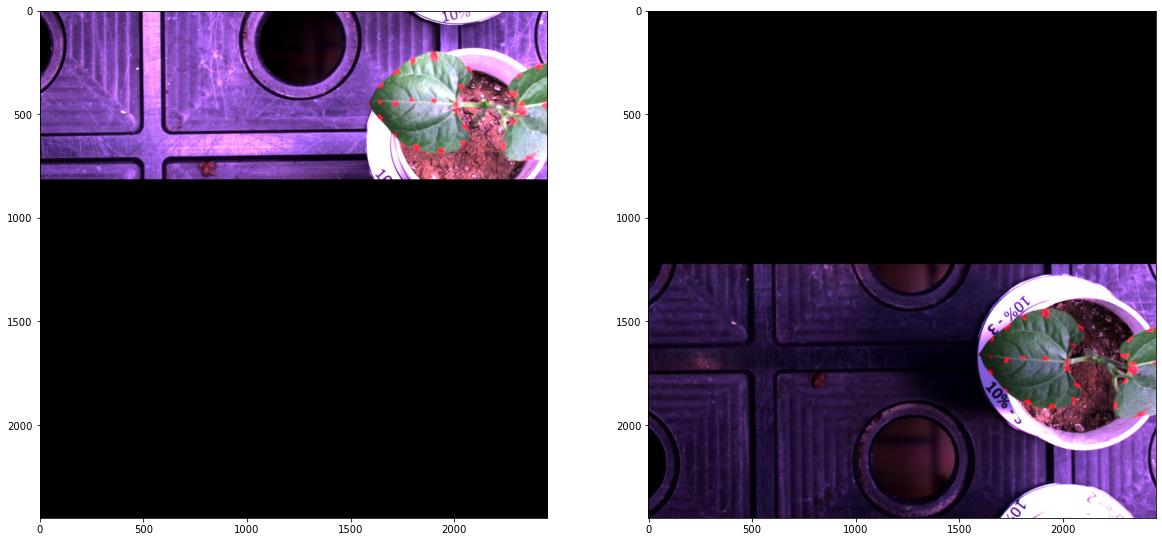

In [3]:
image_1 = cv2.imread("D:/2024_Marten-Thesis/20240314_Spectral_RGB_CLR_bewerkt/C3_10%_3.jpg")
image_2 = cv2.imread("D:/2024_Marten-Thesis/20240314_Spectral_RGB_CLR_bewerkt/C4_10%_3.jpg")

image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.imshow(image_1_rgb)
plt.subplot(1,2,2)
plt.imshow(image_2_rgb)
plt.show()

In [4]:
def find_red_dots(image):
    min_red = np.array([170, 0, 0])  # min. limit Red (RGB)
    max_red = np.array([255, 80, 80])  # max. limit Red (RGB)
    mask = cv2.inRange(image, min_red, max_red)
    #plt.imshow(mask)
    #plt.colorbar()
    
    image_dilated = snd.morphology.binary_dilation(mask, iterations=20)
    #plt.imshow(image_dilated)
    
    mask_labeled = skimage.morphology.label(image_dilated)
    #print(mask)
    #plt.imshow(mask_labeled)
#     plt.imshow(mask_labeled)
#     np.unique(mask_labeled)
#     plt.colorbar()

# Coordinates of centers of objects, filter out too small and too large objects
    min_size = 20
    max_size = 10000
    coords_pred = []
    for o in sorted(np.unique(mask_labeled))[1:]:
        if np.sum(mask_labeled == o) >= min_size and np.sum(mask_labeled == o) <= max_size:
            coords = list(np.mean(np.argwhere(mask_labeled == o), axis=0))
            coords_pred += [coords]
    #print(coords_pred)
    
    return np.array(coords_pred)


In [5]:
red_dot_image_1 = find_red_dots(image_1_rgb)
red_dot_image_2 = find_red_dots(image_2_rgb)
print(red_dot_image_1)
print(red_dot_image_2)

<ipython-input-4-1f2c39df7fb8>:8: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  image_dilated = snd.morphology.binary_dilation(mask, iterations=20)


[[ 276.86210892 2406.09617613]
 [ 288.7928719  2072.55268595]
 [ 303.01669941 1715.59233792]
 [ 366.3362256  1643.06290672]
 [ 368.31720827 2027.73375185]
 [ 435.08251289 2280.95030474]
 [ 421.         2101.        ]
 [ 430.23380567 1787.23380567]
 [ 443.40583554 1639.0464191 ]
 [ 474.26934573 2007.52407838]
 [ 459.         1704.        ]
 [ 517.21610169 1640.85285054]
 [ 521.5        2080.        ]
 [ 563.21332363 2053.10921005]
 [ 583.49856734 2109.67717287]
 [ 600.06918865 1712.97610752]
 [ 603.90699588 2182.50576132]
 [ 642.49060965 2047.27968795]
 [ 691.68713066 1815.40369884]
 [ 707.49081721 2117.1120424 ]
 [ 658.53895582 1748.50843373]
 [ 697.80212766 1939.74212766]
 [ 727.80291411 2329.49539877]
 [ 764.97083603 1900.37005833]
 [ 789.86975717 1848.92273731]
 [ 799.         2127.        ]
 [ 807.         1947.        ]]
[[1462.0584989  1915.17041943]
 [1480.47067138 1812.51342756]
 [1529.656558   1732.72858226]
 [1529.04280618 2084.63337297]
 [1542.64343737 2417.99657973]
 [1587.

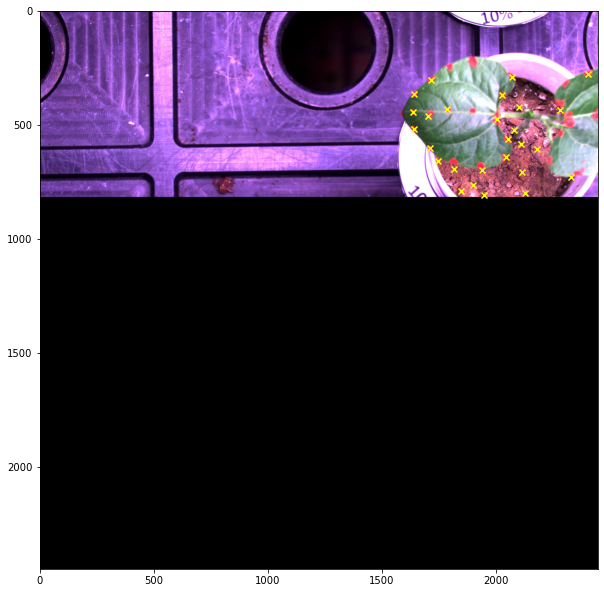

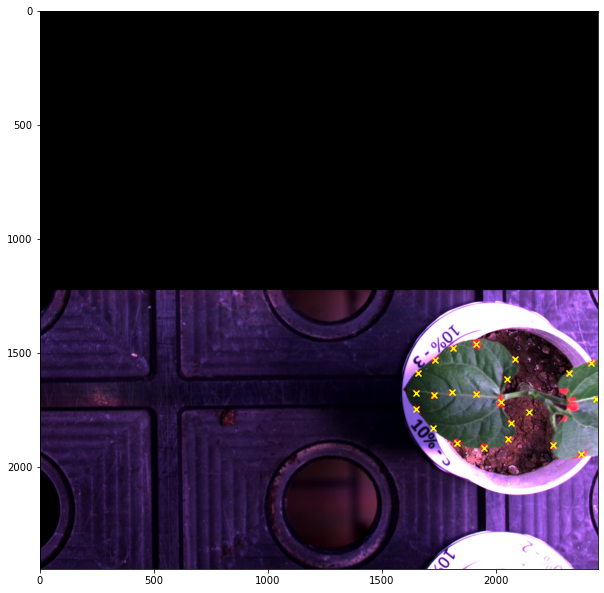

In [6]:
plt.figure(figsize=(10,20))
plt.imshow(image_1_rgb)
X = [c[1]for c in red_dot_image_1]
Y = [c[0]for c in red_dot_image_1]
plt.scatter(X,Y,color='yellow', marker = 'x')

plt.figure(figsize=(10,20))
plt.imshow(image_2_rgb)
X = [c[1]for c in red_dot_image_2]
Y = [c[0]for c in red_dot_image_2]
plt.scatter(X,Y,color='yellow', marker = 'x')

In [7]:
# Opsplitsen in x en y voor image 1&2
y_im1 = red_dot_image_1[:,1]
x_im1 = red_dot_image_1[:,0]
y_im2 = red_dot_image_2[:,1]
x_im2 = red_dot_image_2[:,0]

print("x_im1:",x_im1)
print("y_im1:",y_im1)
print("x_im2:",x_im2)
print("y_im2:",y_im2)

x_im1: [276.86210892 288.7928719  303.01669941 366.3362256  368.31720827
 435.08251289 421.         430.23380567 443.40583554 474.26934573
 459.         517.21610169 521.5        563.21332363 583.49856734
 600.06918865 603.90699588 642.49060965 691.68713066 707.49081721
 658.53895582 697.80212766 727.80291411 764.97083603 789.86975717
 799.         807.        ]
y_im1: [2406.09617613 2072.55268595 1715.59233792 1643.06290672 2027.73375185
 2280.95030474 2101.         1787.23380567 1639.0464191  2007.52407838
 1704.         1640.85285054 2080.         2053.10921005 2109.67717287
 1712.97610752 2182.50576132 2047.27968795 1815.40369884 2117.1120424
 1748.50843373 1939.74212766 2329.49539877 1900.37005833 1848.92273731
 2127.         1947.        ]
x_im2: [1462.0584989  1480.47067138 1529.656558   1529.04280618 1542.64343737
 1587.05887522 1587.6576221  1613.73010573 1673.94640464 1678.98784577
 1675.02081269 1686.03703704 1714.29470803 1702.         1745.63536702
 1758.         1807.2903

In [8]:
# Enkel overeenkomstige punten linken met letter

letters = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'M', 'N', 'P','Q'])

x_im1_letter_pixel = np.array([474.2693457, 563.2133236, 642.4906097, 697.8021277, 691.6871307,
       600.0691887, 517.2161017, 443.4058355, 366.3362256, 303.0166994,
       288.7928719, 368.3172083, 430.2338057, 459.])

y_im1_letter_pixel = np.array([2007.524078, 2053.10921 , 2047.279688, 1939.742128, 1815.403699,
       1712.976108, 1640.852851, 1639.046419, 1643.062907, 1715.592338,
       2072.552686, 2027.733752, 1787.233806, 1704.])

x_im2_letter_pixel = np.array([1714.294708, 1807.290379, 1878.280232, 1917.761312, 1893.510187,
       1830.429187, 1745.635367, 1675.020813, 1587.657622, 1529.656558,
       1529.042806, 1613.730106, 1673.946405, 1686.037037])

y_im2_letter_pixel = np.array([2021.47354 , 2067.638343, 2052.176395, 1950.202339, 1828.44163 ,
       1725.98399 , 1652.173022, 1650.499504, 1657.895905, 1732.728582,
       2084.633373, 2049.853088, 1806.969629, 1727.412551])

print(letters)
print("x_im1:",x_im1_letter_pixel)
print("y_im1:",y_im1_letter_pixel)
print("x_im2:",x_im2_letter_pixel)
print("y_im2:",y_im2_letter_pixel)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'M' 'N' 'P' 'Q']
x_im1: [474.2693457 563.2133236 642.4906097 697.8021277 691.6871307 600.0691887
 517.2161017 443.4058355 366.3362256 303.0166994 288.7928719 368.3172083
 430.2338057 459.       ]
y_im1: [2007.524078 2053.10921  2047.279688 1939.742128 1815.403699 1712.976108
 1640.852851 1639.046419 1643.062907 1715.592338 2072.552686 2027.733752
 1787.233806 1704.      ]
x_im2: [1714.294708 1807.290379 1878.280232 1917.761312 1893.510187 1830.429187
 1745.635367 1675.020813 1587.657622 1529.656558 1529.042806 1613.730106
 1673.946405 1686.037037]
y_im2: [2021.47354  2067.638343 2052.176395 1950.202339 1828.44163  1725.98399
 1652.173022 1650.499504 1657.895905 1732.728582 2084.633373 2049.853088
 1806.969629 1727.412551]


In [9]:
import numpy as np

# Definieer de letters en bijbehorende coördinaten in de twee afbeeldingen
letters = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'M', 'N', 'P', 'Q'])

x_im1_letter_pixel = np.array([474.2693457, 563.2133236, 642.4906097, 697.8021277, 691.6871307,
                               600.0691887, 517.2161017, 443.4058355, 366.3362256, 303.0166994,
                               288.7928719, 368.3172083, 430.2338057, 459.])

y_im1_letter_pixel = np.array([2007.524078, 2053.10921, 2047.279688, 1939.742128, 1815.403699,
                               1712.976108, 1640.852851, 1639.046419, 1643.062907, 1715.592338,
                               2072.552686, 2027.733752, 1787.233806, 1704.])

x_im2_letter_pixel = np.array([1714.294708, 1807.290379, 1878.280232, 1917.761312, 1893.510187,
                               1830.429187, 1745.635367, 1675.020813, 1587.657622, 1529.656558,
                               1529.042806, 1613.730106, 1673.946405, 1686.037037])

y_im2_letter_pixel = np.array([2021.47354, 2067.638343, 2052.176395, 1950.202339, 1828.44163,
                               1725.98399, 1652.173022, 1650.499504, 1657.895905, 1732.728582,
                               2084.633373, 2049.853088, 1806.969629, 1727.412551])

# Maak een dictionary om de gegevens op te slaan
letter_coordinates = {}

# Voeg coördinaten toe aan de dictionary op basis van de letters
for i, letter in enumerate(letters):
    letter_coordinates[letter] = {
        'x_im1': x_im1_letter_pixel[i],
        'y_im1': y_im1_letter_pixel[i],
        'x_im2': x_im2_letter_pixel[i],
        'y_im2': y_im2_letter_pixel[i]
    }

# Print de letter-coördinaten dictionary
print(letter_coordinates)


{'A': {'x_im1': 474.2693457, 'y_im1': 2007.524078, 'x_im2': 1714.294708, 'y_im2': 2021.47354}, 'B': {'x_im1': 563.2133236, 'y_im1': 2053.10921, 'x_im2': 1807.290379, 'y_im2': 2067.638343}, 'C': {'x_im1': 642.4906097, 'y_im1': 2047.279688, 'x_im2': 1878.280232, 'y_im2': 2052.176395}, 'D': {'x_im1': 697.8021277, 'y_im1': 1939.742128, 'x_im2': 1917.761312, 'y_im2': 1950.202339}, 'E': {'x_im1': 691.6871307, 'y_im1': 1815.403699, 'x_im2': 1893.510187, 'y_im2': 1828.44163}, 'F': {'x_im1': 600.0691887, 'y_im1': 1712.976108, 'x_im2': 1830.429187, 'y_im2': 1725.98399}, 'G': {'x_im1': 517.2161017, 'y_im1': 1640.852851, 'x_im2': 1745.635367, 'y_im2': 1652.173022}, 'H': {'x_im1': 443.4058355, 'y_im1': 1639.046419, 'x_im2': 1675.020813, 'y_im2': 1650.499504}, 'I': {'x_im1': 366.3362256, 'y_im1': 1643.062907, 'x_im2': 1587.657622, 'y_im2': 1657.895905}, 'J': {'x_im1': 303.0166994, 'y_im1': 1715.592338, 'x_im2': 1529.656558, 'y_im2': 1732.728582}, 'M': {'x_im1': 288.7928719, 'y_im1': 2072.552686, 'x_

In [10]:
# Voor de letter A de XY-coördinaten voor im1&2

# Haal de coördinaten van de letter 'H' uit de letter_coordinates dictionary
if 'H' in letter_coordinates:
    coordinates_H = letter_coordinates['H']
    x_im1_H = coordinates_H['x_im1']
    y_im1_H = coordinates_H['y_im1']
    x_im2_H = coordinates_H['x_im2']
    y_im2_H = coordinates_H['y_im2']
print("x_im1_H:",x_im1_H)
print("x_im1_H:",y_im1_H)
print("x_im1_H:",x_im2_H)
print("x_im1_H:",y_im2_H)

x_im1_H: 443.4058355
x_im1_H: 1639.046419
x_im1_H: 1675.020813
x_im1_H: 1650.499504


In [19]:
# Camerakalibratie gegevens voor pinhole en focusafstand

# Load calibration data
mtx = np.load('D:/2024_Marten-Thesis/Calibration/mtx.npy')
print("Calibratie-matrix:")
print(mtx)

# Center of image
center = [mtx[0,2], mtx[1,2]]
print("Center image:")
xp = center[0]
yp = center[1]
print(xp,yp)

# Calculate focal distance in mm, as the mean of both
pixel_width = 6.12e-3 #infosheet PathoViewer
f = pixel_width*(mtx[0,0]+mtx[1,1])/2
print("focal_dist(mm):",f)

# Pinholes camera
pinhole = np.array([[ -40, 0, 0],[40, 0, 0]])
print("Pinholes:")
print(pinhole)

# Number of cameras
n_cam = pinhole.shape[0]
print("Aantal camerastandpunten:",n_cam)



Calibratie-matrix:
[[8.55380776e+03 0.00000000e+00 1.19568110e+03]
 [0.00000000e+00 8.54320289e+03 1.26382192e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Center image:
1195.6810956522213 1263.8219195123243
focal_dist(mm): 52.316852588176005
Pinholes:
[[-40   0   0]
 [ 40   0   0]]
Aantal camerastandpunten: 2


In [20]:
x_c3_H = (x_im1_H - xp)*pixel_width + pinhole[0][0]
y_c3_H = (y_im1_H - yp)*pixel_width
z_c3_H = f
w_c3_H = [x_c3_H, y_c3_H, z_c3_H]

print("Worldcoord H uit C3:",w_c3_H)

x_c4_H = (x_im2_H - xp)*pixel_width + pinhole[1][0]
y_c4_H = (y_im2_H - yp)*pixel_width
z_c4_H = f
w_c4_H = [x_c4_H, y_c4_H, z_c4_H]

print("Worldcoord H uit C4:",w_c4_H)

Worldcoord H uit C3: [-44.60392459213159, 2.2963739368645757, 52.316852588176005]
Worldcoord H uit C4: [42.93355907016841, 2.3664668170645746, 52.316852588176005]


In [21]:
# Coefficient and constant matrices
A_c3 = [w_c3_H[0],
        w_c3_H[1],
        w_c3_H[2]]
B_c3 = [pinhole[0][0],
        pinhole[0][1],
        pinhole[0][2]]

A_c4 = [w_c4_H[0],
        w_c4_H[1],
        w_c4_H[2]]
B_c4 = [pinhole[1][0],
        pinhole[1][1],
        pinhole[1][2]]

#print(A_c3)
#print(B_c3)
#print(A_c4)
#print(B_c4)


A = np.array([[-40-x_c3_H, x_c4_H+40],
     [-y_c3_H, y_c4_H],
     [-z_c3_H, z_c4_H]])
B = np.array([[80],
              [0],
              [0]])
print("A")
print(A)
print("B")
print(B)

A
[[  4.60392459  82.93355907]
 [ -2.29637394   2.36646682]
 [-52.31685259  52.31685259]]
B
[[80]
 [ 0]
 [ 0]]


In [14]:
# Least squares solution using numpy's lstsq function
t_est, residuals, rank, singular_values = np.linalg.lstsq(A, B, rcond=None)

print("Estimated coefficients (t_est):", t_est)
print("Residuals:", residuals)
print("Rank of A:", rank)
print("Singular values of A:", singular_values)


Estimated coefficients (t_est): [[0.91394453]
 [0.91389081]]
Residuals: [0.00409544]
Rank of A: 2
Singular values of A: [101.75821378  45.04904992]


In [22]:
# 3D schattingen obv C3 en C4

t_c3 = t_est[0]
t_c4 = t_est[1]
print("t_c3:",t_c3)
print("t_c4:",t_c3)
print("")

x_3D_c3 = B_c3[0] + t_c3*(B_c3[0] - w_c3_H[0])
y_3D_c3 = B_c3[1] + t_c3*(B_c3[1] - w_c3_H[1])
z_3D_c3 = B_c3[2] + t_c3*(B_c3[2] - w_c3_H[2])

P_c3 = np.array([[x_3D_c3],
                 [y_3D_c3],
                 [z_3D_c3]])
print("P_c3: x_3D, y_3D, z_3D")
print(P_c3)
print("")

x_3D_c4 = B_c4[0] + t_c3*(B_c4[0] - w_c4_H[0])
y_3D_c4 = B_c4[1] + t_c3*(B_c4[1] - w_c4_H[1])
z_3D_c4 = B_c4[2] + t_c3*(B_c4[2] - w_c4_H[2])

P_c4 = np.array([[x_3D_c4],
                 [y_3D_c4],
                 [z_3D_c4]])
print("P_c4: x_3D, y_3D, z_3D")
print(P_c4)

t_c3: [0.91394453]
t_c4: [0.91394453]

P_c3: x_3D, y_3D, z_3D
[[[-35.79226829]]

 [[ -2.0987584 ]]

 [[-47.81470134]]]

P_c4: x_3D, y_3D, z_3D
[[[ 37.31888973]]

 [[ -2.16281941]]

 [[-47.81470134]]]


In [23]:
# Gemiddlede van beide 3D-schattingen
P_mean = (P_c3 + P_c4)/2
print(P_mean)

[[[  0.76331072]]

 [[ -2.1307889 ]]

 [[-47.81470134]]]


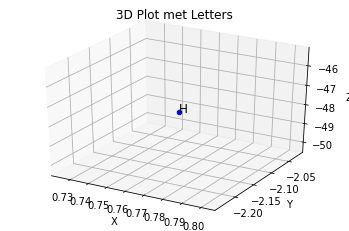

In [18]:
P_mean = P_mean.squeeze() 
x_3D = P_mean[0]
y_3D = P_mean[1]
z_3D = P_mean[2]
letters = ['H']

# Maak een 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_3D, y_3D, z_3D, c='b', marker='o')
ax.text(x_3D, y_3D, z_3D, letters[0], color='black', fontsize=12)

# Voeg labels en titel toe
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot met Letters')

#ax.view_init(elev=15, azim=180)

# Toon de plot
plt.show()

In [ ]:
"""
from mpl_toolkits.mplot3d import Axes3D

# Camera info
position1 = [40, 65, 620]  # XYZ-Camerapositie 1
position2 = [-40, 65, 620]   # XYZ-Camerapositie 2

# Lus door de punten in data LOOP NOG AANPASSEN WANT WEL AL JUISTE 3D COORDINATEN MAAR NOG TE VEEL GELOOPT
# Coördinaten van de camera's
x1, y1, z1 = position1
x2, y2, z2 = position2

# Coördinaten van de punten
x3 = x_im1_letter_mm
y3 = y_im1_letter_mm
z3 = 0

x4 = x_im2_letter_mm
y4 = y_im2_letter_mm
z4 = 0

# Berekenen van 3D-coördinaten van de punten
y_3D_point = ((x2*(y3-y1)*(y4-y2))-(x1*(y3-y1)*(y4-y2))+(y1*(x3-x1)*(y4-y2))-(y2*(x4-x2)*(y3-y1)))/((x3-x1)*(y4-y2)-(x4-x2)*(y3-y1))
x_3D_point = x1 + (x3-x1)*(y_3D_point-y1)/(y4-y2)
z_3D_point = z2 + (z4-z2)*(y_3D_point-y2)/(y4-y2)
print("X_3D: ", x_3D_point)
print("Y_3D: ", y_3D_point)
print("Z_3D: ", z_3D_point)
"""